# Student Engagement Analytics — Analysis
Exploration of `data/students.db` built from the synthetic dataset.

**What this notebook does**
- Connects to the SQLite database
- Runs a few SQL slices (sanity checks)
- Derives grade & attendance bands
- Visualizes at-risk rates
- Saves CSV outputs for the repo


In [1]:
!rm -rf student-engagement-analytics
!git clone https://github.com/hellosultan/student-engagement-analytics.git
%cd student-engagement-analytics

Cloning into 'student-engagement-analytics'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 4), reused 18 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 41.19 KiB | 1.79 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/Users/sultanmuhammad/Documents/GitHub Projects/student-engagement-analytics/student-engagement-analytics


In [2]:
import os, pathlib, sqlite3, numpy as np, pandas as pd
pathlib.Path("data").mkdir(exist_ok=True)
db_path = pathlib.Path("data/students.db")

if not db_path.exists():
    rng = np.random.default_rng(42)
    n = 1000
    df = pd.DataFrame({
        "student_id": np.arange(10001, 10001+n),
        "gender": rng.choice(["Male","Female"], size=n),
        "age": rng.integers(17, 23, size=n),
        "attendance_rate": np.round(rng.uniform(55, 100, size=n), 2),
        "avg_grade": np.round(rng.normal(70, 10, size=n), 1).clip(40, 100),
        "submissions_late_pct": np.round(rng.uniform(0, 45, size=n), 1),
        "activities_count": rng.integers(0, 8, size=n),
        "parent_contacts": rng.integers(0, 3, size=n),
    })
    df["prior_risk_flag"] = ((df["avg_grade"] < 60) | (df["attendance_rate"] < 65)).astype(int)
    df["at_risk"] = (
        (df["avg_grade"] < 65) |
        (df["attendance_rate"] < 70) |
        (df["submissions_late_pct"] > 30) |
        (df["prior_risk_flag"] == 1)
    ).astype(int)
    con_tmp = sqlite3.connect(db_path.as_posix())
    df.to_sql("students", con_tmp, if_exists="replace", index=False)
    con_tmp.close()

print("Ready. DB at:", db_path.as_posix())

Ready. DB at: data/students.db


In [8]:
from pathlib import Path
import sqlite3, pandas as pd
import matplotlib.pyplot as plt

# Display DataFrames without truncation (optional)
pd.set_option("display.max_columns", None)

# Find DB whether notebook is in repo root or /notebooks
candidates = [
    Path.cwd() / "data" / "students.db",
    Path.cwd().parent / "data" / "students.db",
]
db_path = next((p for p in candidates if p.exists()), None)
assert db_path is not None, "Couldn't find data/students.db. Run: python src/sql/load_to_sqlite.py"

con = sqlite3.connect(db_path.as_posix())
print("Connected to:", db_path)


Connected to: /Users/sultanmuhammad/Documents/GitHub Projects/student-engagement-analytics/data/students.db


In [9]:
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table' ORDER BY 1;", con)
tables

,name
0,students


In [10]:
# Row counts per table
tbls = tables['name'].tolist()
for t in tbls:
    n = pd.read_sql(f"SELECT COUNT(*) AS n FROM {t};", con)['n'][0]
    print(f"{t}: {n} rows")

students: 1000 rows


## Quick Peek

In [11]:
pd.read_sql("SELECT * FROM students LIMIT 5;", con)

,student_id,gender,age,attendance_rate,avg_grade,submissions_late_pct,activities_count,parent_contacts,prior_risk_flag,at_risk
0,10001,Male,21,65.27,79.6,28.4,1,1,0,0
1,10002,Female,17,93.55,62.5,38.8,2,1,0,0
2,10003,Female,21,85.05,72.4,12.9,5,0,0,0
3,10004,Female,22,55.53,70.7,29.4,2,2,1,0
4,10005,Male,21,87.65,60.3,20.2,0,0,0,0


## Sanity Metrics
Basic value ranges to make sure the data looks sensible.

In [12]:
pd.read_sql("""
SELECT
  COUNT(*) AS rows,
  MIN(avg_grade)   AS min_grade,
  MAX(avg_grade)   AS max_grade,
  MIN(attendance_rate) AS min_attendance,
  MAX(attendance_rate) AS max_attendance,
  MIN(submissions_late_pct) AS min_late_pct,
  MAX(submissions_late_pct) AS max_late_pct
FROM students;
""", con)

,rows,min_grade,max_grade,min_attendance,max_attendance,min_late_pct,max_late_pct
0,1000,27.5,100.0,24.95,99.56,0.5,77.1


## Grade Bands (derived from `avg_grade`)

In [13]:
grade_bands = pd.read_sql("""
SELECT
  CASE
    WHEN avg_grade >= 85 THEN 'A'
    WHEN avg_grade >= 70 THEN 'B'
    WHEN avg_grade >= 55 THEN 'C'
    ELSE 'D/F'
  END AS grade_band,
  COUNT(*)                           AS n_students,
  ROUND(AVG(attendance_rate),2)      AS avg_attendance_pct,
  ROUND(AVG(submissions_late_pct),2) AS avg_late_pct,
  ROUND(AVG(activities_count),2)     AS avg_activities,
  ROUND(AVG(at_risk),3)              AS at_risk_rate
FROM students
GROUP BY 1
ORDER BY 1;
""", con)
grade_bands

,grade_band,n_students,avg_attendance_pct,avg_late_pct,avg_activities,at_risk_rate
0,A,111,75.61,23.86,2.17,0.018
1,B,376,74.74,25.44,2.14,0.016
2,C,386,74.07,25.11,2.16,0.005
3,D/F,127,73.97,25.01,2.19,0.039


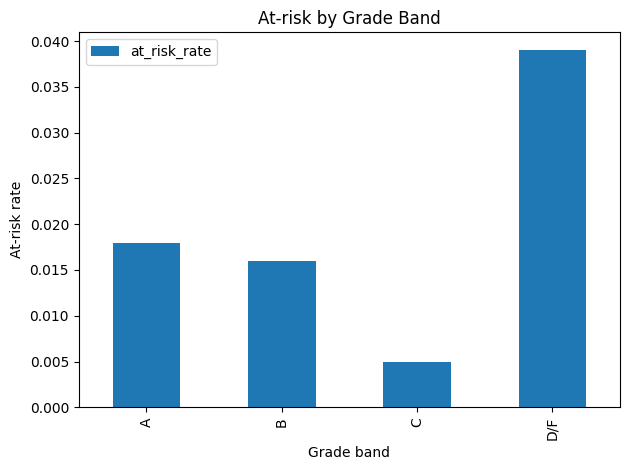

In [14]:
ax = grade_bands.plot(x="grade_band", y="at_risk_rate", kind="bar")
ax.set_xlabel("Grade band")
ax.set_ylabel("At-risk rate")
ax.set_title("At-risk by Grade Band")
plt.tight_layout(); plt.show()


## Attendance Buckets (from `attendance_rate`)

In [15]:
attendance_buckets = pd.read_sql("""
SELECT
  CASE
    WHEN attendance_rate < 60 THEN '<60'
    WHEN attendance_rate < 75 THEN '60-75'
    WHEN attendance_rate < 90 THEN '75-90'
    ELSE '90-100'
  END AS attendance_bucket,
  COUNT(*)              AS n_students,
  ROUND(AVG(at_risk),3) AS at_risk_rate
FROM students
GROUP BY 1
ORDER BY CASE attendance_bucket
  WHEN '<60' THEN 1 WHEN '60-75' THEN 2 WHEN '75-90' THEN 3 ELSE 4 END;
""", con)
attendance_buckets

,attendance_bucket,n_students,at_risk_rate
0,<60,160,0.025
1,60-75,310,0.019
2,75-90,389,0.010
3,90-100,141,0.007


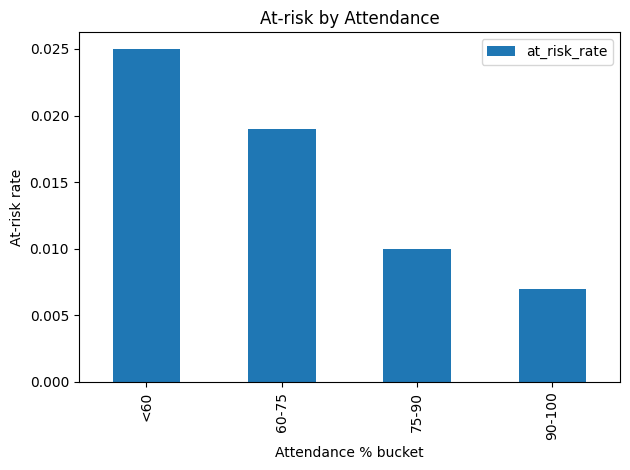

In [16]:
ax = attendance_buckets.plot(x="attendance_bucket", y="at_risk_rate", kind="bar")
ax.set_xlabel("Attendance % bucket")
ax.set_ylabel("At-risk rate")
ax.set_title("At-risk by Attendance")
plt.tight_layout(); plt.show()

## Gender Breakdown

In [17]:
by_gender = pd.read_sql("""
SELECT gender,
       COUNT(*) AS n_students,
       ROUND(AVG(avg_grade),2) AS avg_grade,
       ROUND(AVG(attendance_rate),2) AS avg_attendance,
       ROUND(AVG(at_risk),3) AS at_risk_rate
FROM students
GROUP BY gender
ORDER BY gender;
""", con)
by_gender


,gender,n_students,avg_grade,avg_attendance,at_risk_rate
0,Female,514,70.15,74.43,0.014
1,Male,486,68.74,74.53,0.016


## Export Results (for GitHub)
CSV outputs go to `reports/figures/` so they show up in your repo.

In [18]:
import os
os.makedirs("reports/figures", exist_ok=True)
grade_bands.to_csv("reports/figures/grade_bands.csv", index=False)
attendance_buckets.to_csv("reports/figures/risk_by_attendance_decile.csv", index=False)
by_gender.to_csv("reports/figures/by_gender.csv", index=False)
print("Saved CSVs to reports/figures/")

Saved CSVs to reports/figures/


## Close Connection

In [20]:
con.close()